In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib import pyplot
from itertools import cycle
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Activites are the class labels , It is six class classification

In [3]:
Activities={0:'WALKING',1:'WALKING_UPSTAIRS',2:'WALKING_DOWNSTAIRS',3:'SITTING',4:'STANDING',5:'LAYING'}

# Function for confusion matrix

In [4]:
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([Activities[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([Activities[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

# Data Preparation

In [5]:
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:
def read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(read_csv(filename).as_matrix()) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))    

In [7]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [8]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [9]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\Users\RAJAN SHRIVASTAVA\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
C:\Users\RAJAN SHRIVASTAVA\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


# Deep Learning Model

In [10]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
tf.reset_default_graph()

In [11]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [12]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [13]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout,Flatten

In [14]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

# Utilty function to count the number of classes

In [15]:
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [16]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


# Defining the architecture of the LSTM

In [16]:
model=Sequential()
model.add(LSTM(n_hidden,return_sequences=True,input_shape=(timesteps,input_dim)))
model.add(Dropout(0.5))
#model.add(Flatten())
model.add(Dense(n_classes,activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 128, 6)            198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [18]:
# Training the model
history=model.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test,Y_test),epochs=epochs)


Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 69s 9ms/step - loss: 1.2117 - acc: 0.3679 - val_loss: 1.9588 - val_acc: 0.3342
Epoch 2/30
7352/7352 [==============================] - 68s 9ms/step - loss: 1.0953 - acc: 0.3598 - val_loss: 1.9825 - val_acc: 0.3342
Epoch 3/30
7352/7352 [==============================] - 69s 9ms/step - loss: 1.0220 - acc: 0.3606 - val_loss: 1.2422 - val_acc: 0.3342
Epoch 4/30
7352/7352 [==============================] - 68s 9ms/step - loss: 0.9597 - acc: 0.3677 - val_loss: 1.1528 - val_acc: 0.3342
Epoch 5/30
7352/7352 [==============================] - 69s 9ms/step - loss: 0.8858 - acc: 0.3876 - val_loss: 1.1031 - val_acc: 0.3366
Epoch 6/30
7352/7352 [==============================] - 68s 9ms/step - loss: 0.8033 - acc: 0.4038 - val_loss: 1.1379 - val_acc: 0.3288
Epoch 7/30
7352/7352 [==============================] - 68s 9ms/step - loss: 0.7785 - acc: 0.4163 - val_loss: 0.9437 - val_acc: 0.3688
Epoch 8

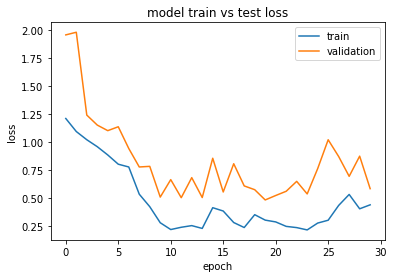

In [19]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs test loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [20]:
Y_pred=model.predict(X_test)

In [21]:
# Confusion Matrix
print(confusion_matrix(Y_test,Y_pred))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 477        0         0        0                   0   
SITTING                  0      325       140        4                   0   
STANDING                 0       71       450       10                   0   
WALKING                  0        3         3      463                  26   
WALKING_DOWNSTAIRS       0        0         0        0                 417   
WALKING_UPSTAIRS         0       11         1       18                   5   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            60  
SITTING                           22  
STANDING                           1  
WALKING                            1  
WALKING_DOWNSTAIRS                 3  
WALKING_UPSTAIRS                 436  


In [22]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 3s 1ms/step


In [23]:
score

[0.5846378747959546, 0.8713946386155412]

# Hyperparameter tunning of the number of  LSTM cell in one Layer and dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16)                1664      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
Total params: 1,766
Trainable params: 1,766
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 60s 8ms/step - loss: 1.4954 - acc: 0.3516 - val_loss: 1.3911 - val_acc: 0.4462
Epoch 2/30
7352/7352 [==============================] - 55s 8ms/step - loss: 1.2374 - acc: 0.4698 - val_loss: 1.2140 - val_acc: 0.4795
Epoch 3/30
7352/7352 [==============================] - 56s 8ms/step - loss: 1.1423 - 

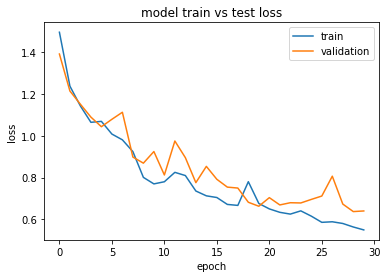

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 16)                1664      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 102       
Total params: 1,766
Trainable params: 1,766
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 56s 8ms/step - loss: 1.4643 - acc: 0.4143 - val_loss: 1.1315 - val_acc: 0.5076
Epoch 2/30
7352/7352 [==============================] - 55s 7ms/step - loss: 1.1489 - acc: 0.5095 - val_loss: 1.4716 - val_acc: 0.3342
Epoch 3/30
7352/7352 [==============================] - 55s 7ms/step - loss: 1.1182 - 

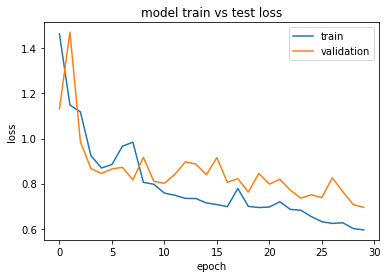

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 16)                1664      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 102       
Total params: 1,766
Trainable params: 1,766
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 55s 8ms/step - loss: 1.6170 - acc: 0.3169 - val_loss: 1.3952 - val_acc: 0.4591
Epoch 2/30
7352/7352 [==============================] - 57s 8ms/step - loss: 1.3280 - acc: 0.4540 - val_loss: 1.2399 - val_acc: 0.4886
Epoch 3/30
7352/7352 [==============================] - 64s 9ms/step - loss: 1.1914 - 

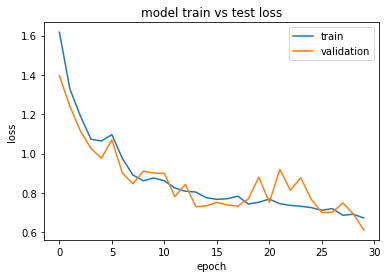

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 16)                1664      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 102       
Total params: 1,766
Trainable params: 1,766
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 63s 9ms/step - loss: 1.6071 - acc: 0.3128 - val_loss: 1.4180 - val_acc: 0.3889
Epoch 2/30
7352/7352 [==============================] - 66s 9ms/step - loss: 1.4019 - acc: 0.3837 - val_loss: 1.3307 - val_acc: 0.4221
Epoch 3/30
7352/7352 [==============================] - 64s 9ms/step - loss: 1.3193 - 

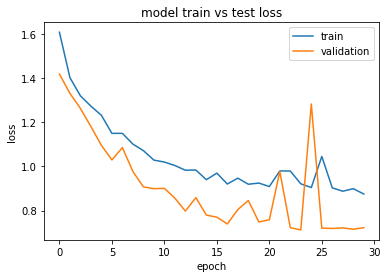

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 66s 9ms/step - loss: 1.3687 - acc: 0.4416 - val_loss: 1.1992 - val_acc: 0.4483
Epoch 2/30
7352/7352 [==============================] - 65s 9ms/step - loss: 1.0795 - acc: 0.5322 - val_loss: 1.1176 - val_acc: 0.5076
Epoch 3/30
7352/7352 [==============================] - 64s 9ms/step - loss: 0.9457 - 

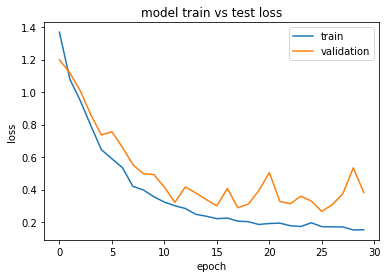

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 70s 10ms/step - loss: 1.3594 - acc: 0.4431 - val_loss: 1.2212 - val_acc: 0.4608
Epoch 2/30
7352/7352 [==============================] - 74s 10ms/step - loss: 1.1288 - acc: 0.5143 - val_loss: 1.0714 - val_acc: 0.5796
Epoch 3/30
7352/7352 [==============================] - 76s 10ms/step - loss: 0.9237

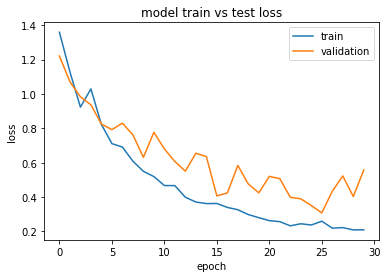

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 61s 8ms/step - loss: 1.4199 - acc: 0.3705 - val_loss: 1.2584 - val_acc: 0.4544
Epoch 2/30
7352/7352 [==============================] - 63s 9ms/step - loss: 1.1429 - acc: 0.5044 - val_loss: 1.0910 - val_acc: 0.5178
Epoch 3/30
7352/7352 [==============================] - 65s 9ms/step - loss: 0.9407 - 

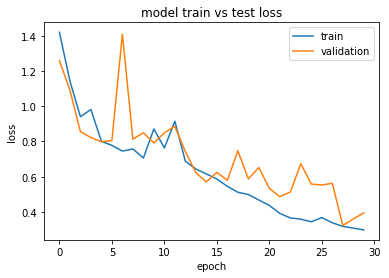

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 71s 10ms/step - loss: 1.4349 - acc: 0.4112 - val_loss: 1.2425 - val_acc: 0.4656
Epoch 2/30
7352/7352 [==============================] - 73s 10ms/step - loss: 1.2181 - acc: 0.4723 - val_loss: 1.1591 - val_acc: 0.4815
Epoch 3/30
7352/7352 [==============================] - 73s 10ms/step - loss: 1.1600

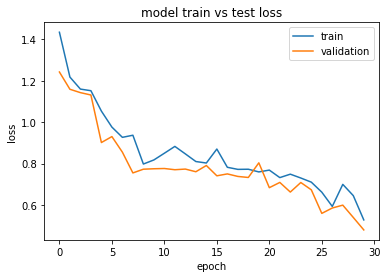

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 64)                18944     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 80s 11ms/step - loss: 1.3071 - acc: 0.4211 - val_loss: 1.2042 - val_acc: 0.4547
Epoch 2/30
7352/7352 [==============================] - 79s 11ms/step - loss: 1.3577 - acc: 0.4697 - val_loss: 1.1550 - val_acc: 0.4913
Epoch 3/30
7352/7352 [==============================] - 79s 11ms/step - loss: 0.95

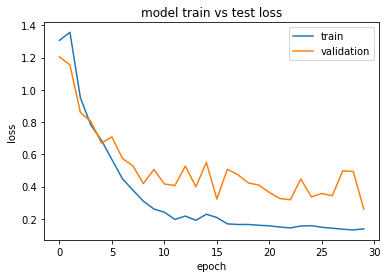

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 64)                18944     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 80s 11ms/step - loss: 1.2968 - acc: 0.4165 - val_loss: 1.2463 - val_acc: 0.4150
Epoch 2/30
7352/7352 [==============================] - 78s 11ms/step - loss: 1.0764 - acc: 0.5182 - val_loss: 0.9829 - val_acc: 0.5877
Epoch 3/30
7352/7352 [==============================] - 79s 11ms/step - loss: 0.95

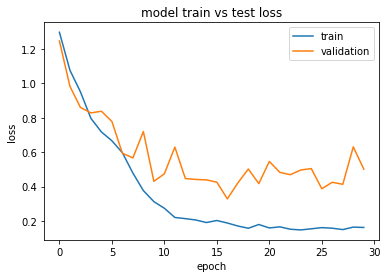

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 64)                18944     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 80s 11ms/step - loss: 1.2569 - acc: 0.4569 - val_loss: 1.2881 - val_acc: 0.4639
Epoch 2/30
7352/7352 [==============================] - 79s 11ms/step - loss: 0.9745 - acc: 0.5800 - val_loss: 0.8511 - val_acc: 0.6118
Epoch 3/30
7352/7352 [==============================] - 79s 11ms/step - loss: 0.82

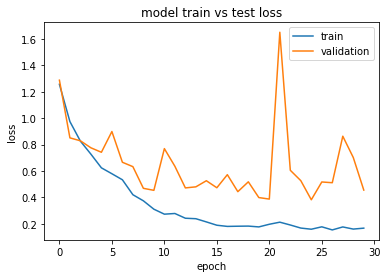

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 64)                18944     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 80s 11ms/step - loss: 1.3547 - acc: 0.4244 - val_loss: 1.1586 - val_acc: 0.5341
Epoch 2/30
7352/7352 [==============================] - 78s 11ms/step - loss: 1.0628 - acc: 0.5269 - val_loss: 0.8964 - val_acc: 0.5816
Epoch 3/30
7352/7352 [==============================] - 78s 11ms/step - loss: 0.85

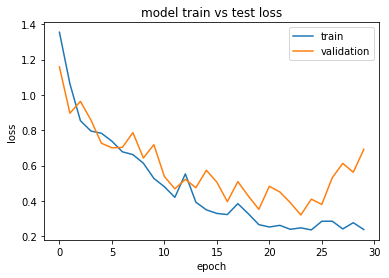

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 128)               70656     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 148s 20ms/step - loss: 1.2589 - acc: 0.4525 - val_loss: 1.1534 - val_acc: 0.4669
Epoch 2/30
7352/7352 [==============================] - 146s 20ms/step - loss: 1.0978 - acc: 0.5027 - val_loss: 0.9955 - val_acc: 0.5480
Epoch 3/30
7352/7352 [==============================] - 146s 20ms/step - loss: 1

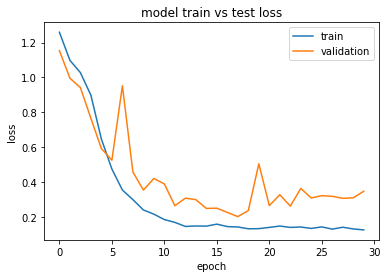

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 128)               70656     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 157s 21ms/step - loss: 1.3269 - acc: 0.4090 - val_loss: 1.2274 - val_acc: 0.4279
Epoch 2/30
7352/7352 [==============================] - 155s 21ms/step - loss: 1.1319 - acc: 0.4888 - val_loss: 0.9992 - val_acc: 0.5256
Epoch 3/30
7352/7352 [==============================] - 155s 21ms/step - loss: 1

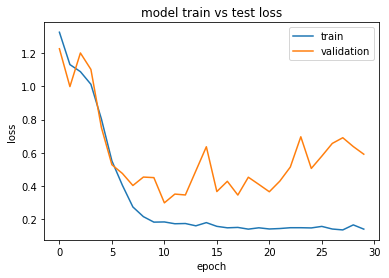

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 128)               70656     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 153s 21ms/step - loss: 1.2623 - acc: 0.4529 - val_loss: 1.1256 - val_acc: 0.4930
Epoch 2/30
7352/7352 [==============================] - 151s 21ms/step - loss: 1.0579 - acc: 0.5182 - val_loss: 0.9657 - val_acc: 0.5551
Epoch 3/30
7352/7352 [==============================] - 151s 21ms/step - loss: 0

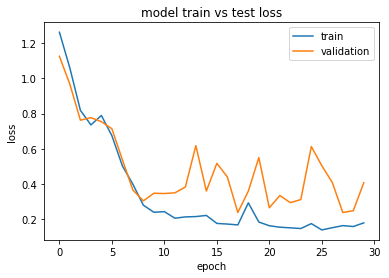

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 128)               70656     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 159s 22ms/step - loss: 1.3205 - acc: 0.4230 - val_loss: 1.1452 - val_acc: 0.4808
Epoch 2/30
7352/7352 [==============================] - 157s 21ms/step - loss: 1.2442 - acc: 0.4729 - val_loss: 1.1806 - val_acc: 0.5087
Epoch 3/30
7352/7352 [==============================] - 157s 21ms/step - loss: 0

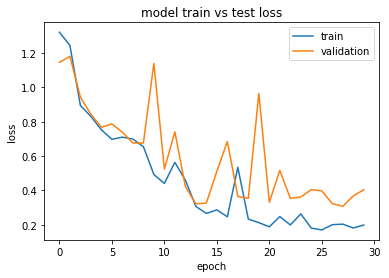

In [24]:
n_hiddens = [16,32,64,128]
drop_out = [0.5,0.6,0.7,0.8]

for i in n_hiddens:
    for j in drop_out:
        model_1=Sequential()
        model_1.add(LSTM(i,input_shape=(timesteps,input_dim)))
        model_1.add(Dropout(j))
   
        model_1.add(Dense(n_classes,activation='sigmoid'))
        model_1.summary()
# Compiling the model
        model_1.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
        history=model_1.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test,Y_test),epochs=epochs)
        pyplot.plot(history.history['loss'])
        pyplot.plot(history.history['val_loss'])
        pyplot.title('model train vs test loss')
        pyplot.ylabel('loss')
        pyplot.xlabel('epoch')
        pyplot.legend(['train', 'validation'], loc='upper right')
        pyplot.show()

# Running the model on the best hyperparameters

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 193s 26ms/step - loss: 1.1509 - ac

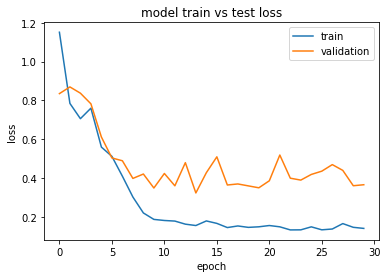

In [17]:
model_2=Sequential()
model_2.add(LSTM(64,return_sequences=True,input_shape=(timesteps,input_dim)))
model_2.add(Dropout(0.6))
model_2.add(LSTM(64))
model_2.add(Dropout(0.6))

    #model.add(Flatten())
model_2.add(Dense(n_classes,activation='sigmoid'))
model_2.summary()
# Compiling the model
model_2.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
history=model_2.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test,Y_test),epochs=epochs)
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs test loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()


In [18]:
Y_pred_1=model_2.predict(X_test)

In [19]:
# Confusion Matrix
print(confusion_matrix(Y_test,Y_pred_1))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 520        0         0        0                   0   
SITTING                  0      427        57        0                   0   
STANDING                 0       98       434        0                   0   
WALKING                  0        0         0      454                  23   
WALKING_DOWNSTAIRS       0        0         0        1                 419   
WALKING_UPSTAIRS         0        3         1        0                   7   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            17  
SITTING                            7  
STANDING                           0  
WALKING                           19  
WALKING_DOWNSTAIRS                 0  
WALKING_UPSTAIRS                 460  


In [20]:
score_2 = model_2.evaluate(X_test, Y_test)

2947/2947 [==============================] - 11s 4ms/step


In [21]:
print(score_2)

[0.36544307469949266, 0.9209365456396336]


# Plotting the ROC curve

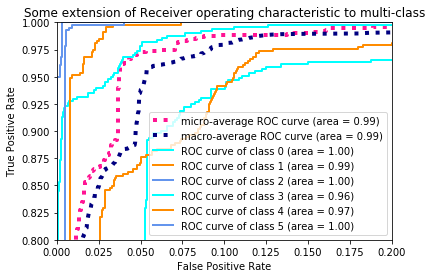

In [26]:
lw=2
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=Y_test.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_pred_1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    
    
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), Y_pred_1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


#***************************
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Observation

In [10]:
data={'Accuracy':[0.9627,0.9678,0.9627,0.8656,0.9162,0.9162,0.9240],'Error':[0.03733,0.03224,0.037334,0.1344,0.08381,0.08381,0.0760]}

In [11]:
pd.DataFrame(data,index=['Logistic Regession','Linear SVC','RBF SVM Classifier','Decision Tree','Random Forest','Gradient Boosting DT','LSTM'])

,Accuracy,Error
Logistic Regession,0.9627,0.037330
Linear SVC,0.9678,0.032240
RBF SVM Classifier,0.9627,0.037334
Decision Tree,0.8656,0.134400
Random Forest,0.9162,0.083810
Gradient Boosting DT,0.9162,0.083810
LSTM,0.9240,0.076000
